# 404 Autoencoder

View more, visit my tutorial page: https://mofanpy.com/tutorials/
My Youtube Channel: https://www.youtube.com/user/MorvanZhou
Dependencies:

* torch: 0.1.11
* matplotlib
* numpy

In [35]:
import torch
import torch.nn as nn
from sympy.physics.control.control_plots import matplotlib
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline

In [36]:
torch.manual_seed(1)    # reproducible

In [37]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

In [38]:
# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./data/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

torch.Size([60000, 28, 28])
torch.Size([60000, 28, 28])


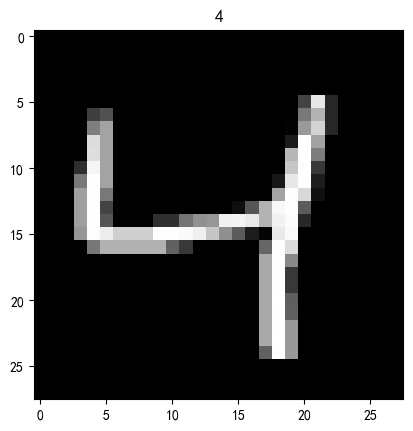

In [54]:
# plot one example
print(train_data.data.size())     # (60000, 28, 28)
print(train_data.data.size())   # (60000)
plt.imshow(train_data.data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.targets[2])
plt.show()

In [55]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [56]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [58]:
autoencoder = AutoEncoder()
print(autoencoder)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()

# original data (first row) for viewing
view_data = Variable(train_data.data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


Epoch:  0 | train loss: 0.2330


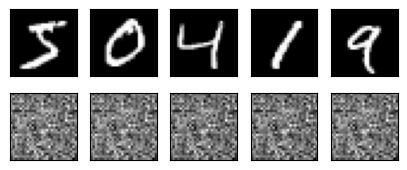

Epoch:  0 | train loss: 0.0608


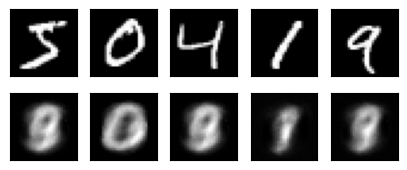

Epoch:  5 | train loss: 0.0367


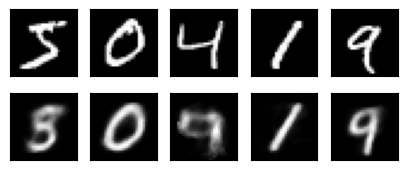

Epoch:  5 | train loss: 0.0402


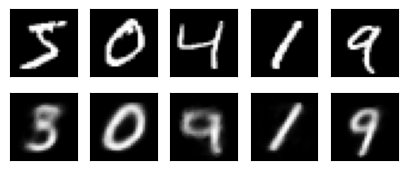

Epoch:  9 | train loss: 0.0352


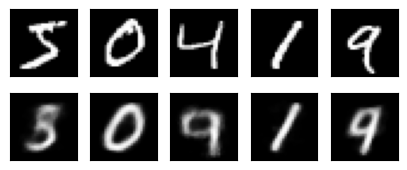

Epoch:  9 | train loss: 0.0396


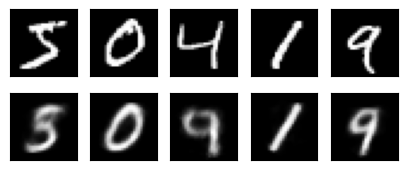

In [43]:
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 28*28))   # batch x, shape (batch, 28*28)
        b_y = Variable(x.view(-1, 28*28))   # batch y, shape (batch, 28*28)
        b_label = Variable(y)               # batch label

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.detach())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show()


In [44]:
# visualize in 3D plot 为接下来的可视化准备数据
view_data = Variable(train_data.data[:200].view(-1, 28*28).type(torch.FloatTensor)/255.)
encoded_data, _ = autoencoder(view_data)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()
values = train_data.targets[:200].numpy()

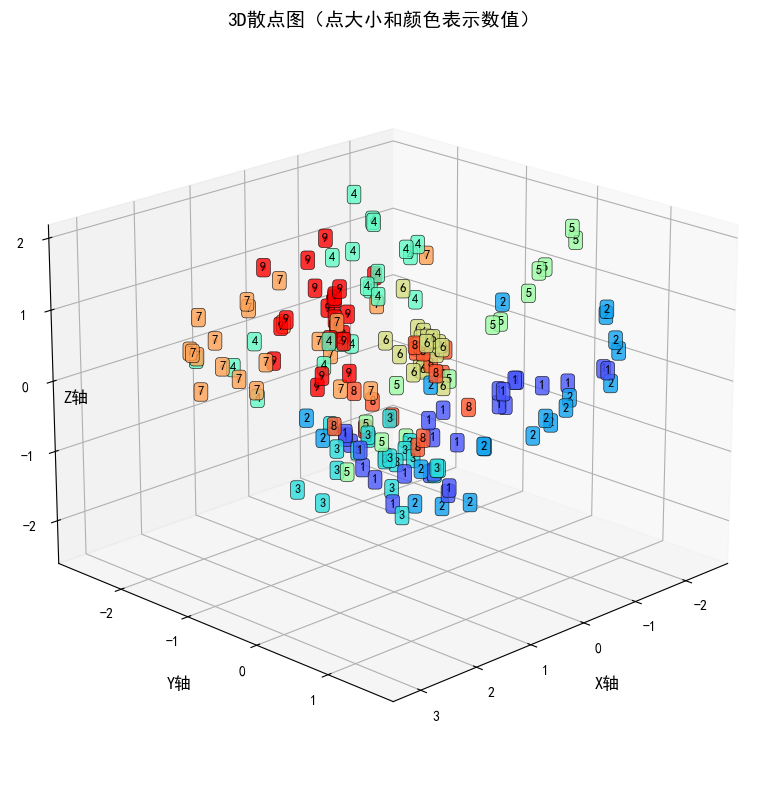

In [53]:
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 创建图形和3D坐标轴
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')  # 使用推荐的方式创建3D坐标轴

# 创建颜色映射
norm = matplotlib.colors.Normalize(vmin=min(values), vmax=max(values))
color_map = cm.rainbow

# 绘制散点图，使用颜色映射和大小映射
scatter = ax.scatter(X, Y, Z,
                    s=values,  # 点的大小与values成正比
                    c=values,   # 点的颜色与values成正比
                    cmap=color_map,
                    alpha=0.7,
                    edgecolors='black',
                    linewidth=0.5,
                    norm=norm)

# 只为部分点添加标签，避免过于拥挤
# 选择values值较大的点添加标签
threshold = np.percentile(values, 0)  # 只给值最大的30%的点添加标签

for x, y, z, s in zip(X, Y, Z, values):
    if s > threshold:
        # 使用与散点图相同的颜色映射
        color = color_map(norm(s))
        ax.text(x, y, z, f'{s}',
                fontsize=9,
                fontweight='bold',
                ha='center',
                va='center',
                bbox=dict(boxstyle="round,pad=0.3",
                         facecolor=color,
                         alpha=0.8,
                         edgecolor='black',
                         linewidth=0.5))

# 设置坐标轴范围
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())

# 添加坐标轴标签
ax.set_xlabel('X轴', fontsize=12, labelpad=10)
ax.set_ylabel('Y轴', fontsize=12, labelpad=10)
ax.set_zlabel('Z轴', fontsize=12, labelpad=-30)

# 添加标题
ax.set_title('3D散点图（点大小和颜色表示数值）', fontsize=14)

# 调整视角
ax.view_init(elev=20, azim=45)  # 设置初始视角

# 添加网格
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()